## Klasyfikacja ręcznie pisanych liczb - MNIST

Po wykonaniu poprzedniego zadania zleceniodawca znów zadzwonił do Ciebie z kolejnym zadaniem. Okazuje się, że nie wszystkie informacje trafiły do zbioru Tytanic. Brakowało w nim między innymi informacji o pokojach w których mieszkali pasażerowie. Wszystkie informacje o miejscu spania były bowiem zapisane odręcznie na kartkach. Tajemniczy  więc zlecił Ci nowe zadanie... **Stworzenie konwolucyjnej sieci neuronowej rozpoznającej ręcznie pisane cyfry.**

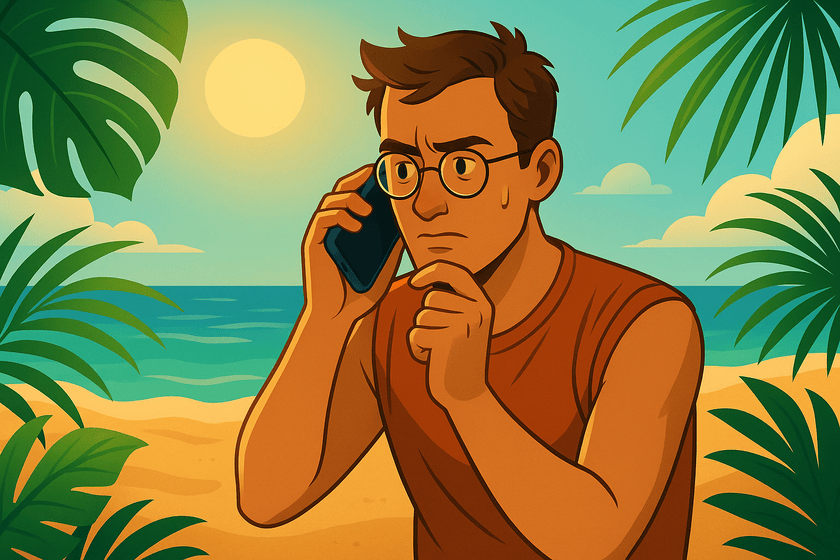

(*AI-generated image*)

Twoim celem będzie jest wytrenowanie modelu widzenia komputerowego (CNN) do klasyfikacji każdej ręcznie pisanej liczby z jak najlepszą dokładnością.

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:

- Co mój model robi i w jaki sposób?
- Na czym skupia się mój model?
- Jakie liczby mój model myli? Dlaczego?
- Jak uodpornić mój model?
- Jaki wynik klasyfikacji możemy uznać za *dobry*?


Wymagania:
- Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?
- Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie zwykła sieć (nie musi być na wszystkich próbkach - zajmie to długo)
- W badaniach użyj wybranych metryk. Wybór uzasadnij.
- Spróbuj dobrać strukture sieci (szerokość i wysokość) i sprawdź jaki ma wpływ na dokładność
- Ćwiczenie: zmień liczbę kanałów/warstw, dodaj BatchNorm, spróbuj zwiększyć/zmniejszyć dropout.
- Wypisz wnioski.
- Korzystaj z `PyTorch` (`torch, torchvision`)

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

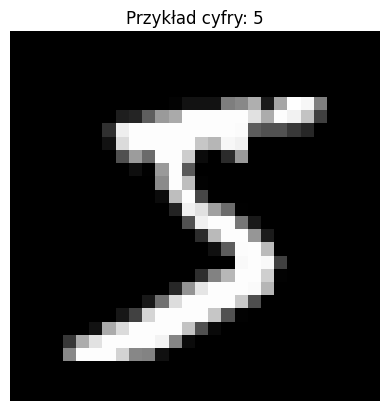

In [81]:
# ładowanie zbioru danych
import tensorflow as tf
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


plt.imshow(x_train[0], cmap='gray')
plt.title(f"Przykład cyfry: {y_train[0]}")
plt.axis('off')
plt.show()

# Import

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report
import os
import itertools

# Dane

In [83]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_root = './data'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train = datasets.MNIST(root=data_root, train=True, download=True, transform=transform)
test_ds = datasets.MNIST(root=data_root, train=False, download=True, transform=transform)
len(train)

val_size = 5000
train_size = len(train) - val_size
train_ds, val_ds = random_split(train, [train_size, val_size])

len(train_ds), (len(val_ds)), (len(test_ds))

(55000, 5000, 10000)

In [84]:
batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# Podgląd danych

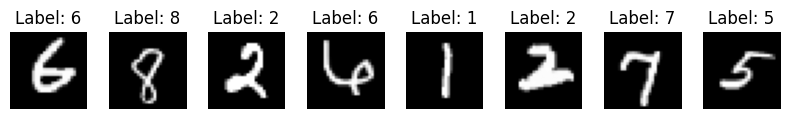

In [85]:
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(1, 8, figsize = (10, 1))
for i in range(8):
  axes[i].imshow(images[i][0], cmap = 'grey')
  axes[i].set_title(f'Label: {labels[i]}')
  axes[i].axis('off')

# Funkcja treningu i ewaluacji

In [86]:
def run_epoch(model, data_loader, criterion, optimizer=None, train=True, current_epoch=None, total_epochs=None, device='cpu'):
    if train and optimizer is None:
      raise ValueError('Optimizer must be provided in training mode!')
    if current_epoch is None or total_epochs is None:
      raise ValueError('Both current_epoch and total_epochs must be provided!')

    model.to(device)
    model.train() if train else model.eval()

    total_loss = 0
    correct = 0
    total = 0

    for data, label in data_loader:
        data, label = data.to(device), label.to(device)

        if train:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
        else:
            with torch.no_grad():
                output = model(data)
                loss = criterion(output, label)

        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += (pred == label).sum().item()
        total += label.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = 100 * correct / total
    mode = 'Train' if train else 'Eval'
    print(f'Epoch {current_epoch}/{total_epochs} (Mode: {mode}) - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%.')

    return avg_loss, accuracy

# NN - Neural Network (baseline)

Moim punktem wyjścia będzie najbardziej prymitywny model jaki się da zrobić (chyba) - potem będę go ulepszać i obserwować poprawę działania.

Model (perceptron jednopoziomowy):

In [87]:
class Baseline(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc = nn.Linear(in_features=28*28, out_features=10)
  def forward(self, x):
    x = x.flatten(start_dim=1)
    x = self.fc(x)
    return x

Trening i ewaluacja modelu:

In [88]:
model_NN = Baseline()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_NN.parameters(), lr=0.01)

epochs=5
epochs_range = range(1, epochs + 1)

train_loss_NN = []
train_acc_NN = []
val_loss_NN = []
val_acc_NN =[]

for epoch in epochs_range:
    train_loss, train_acc = run_epoch(model_NN, train_loader, criterion, optimizer, train=True, current_epoch=epoch, total_epochs=epochs)
    val_loss, val_acc = run_epoch(model_NN, val_loader, criterion, train=False, current_epoch=epoch, total_epochs=epochs)
    train_loss_NN.append(train_loss)
    train_acc_NN.append(train_acc)
    val_loss_NN.append(val_loss)
    val_acc_NN.append(val_acc)

Epoch 1/5 (Mode: Train) - Loss: 0.4802, Accuracy: 86.93%.
Epoch 1/5 (Mode: Eval) - Loss: 0.3503, Accuracy: 90.10%.
Epoch 2/5 (Mode: Train) - Loss: 0.3371, Accuracy: 90.45%.
Epoch 2/5 (Mode: Eval) - Loss: 0.3212, Accuracy: 90.66%.
Epoch 3/5 (Mode: Train) - Loss: 0.3149, Accuracy: 91.10%.
Epoch 3/5 (Mode: Eval) - Loss: 0.3079, Accuracy: 91.08%.
Epoch 4/5 (Mode: Train) - Loss: 0.3030, Accuracy: 91.39%.
Epoch 4/5 (Mode: Eval) - Loss: 0.2962, Accuracy: 91.30%.
Epoch 5/5 (Mode: Train) - Loss: 0.2957, Accuracy: 91.65%.
Epoch 5/5 (Mode: Eval) - Loss: 0.2916, Accuracy: 91.46%.


Wizualizacja:

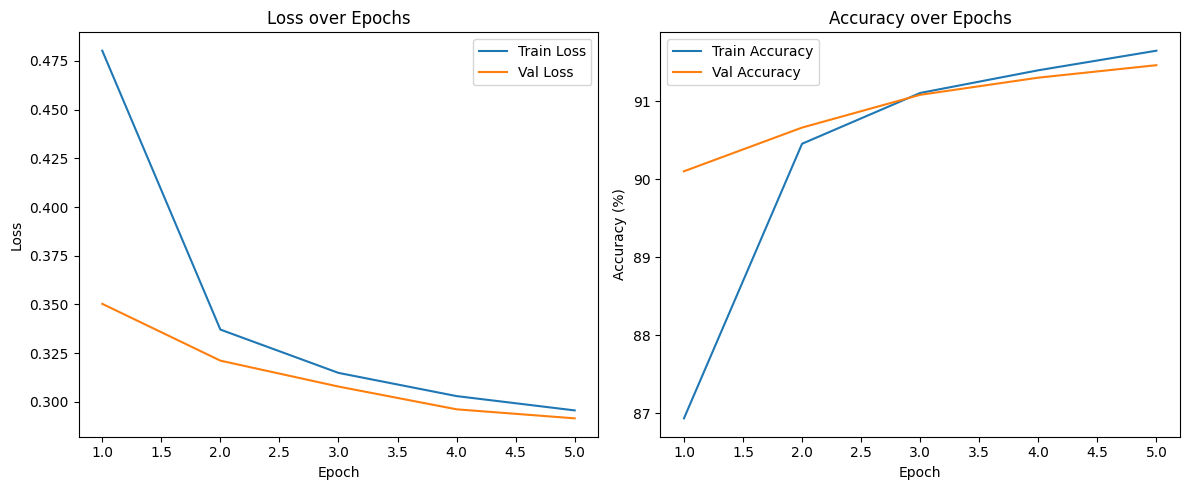

In [89]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_NN, label='Train Loss')
plt.plot(epochs_range, val_loss_NN, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc_NN, label='Train Accuracy')
plt.plot(epochs_range, val_acc_NN, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# MLP - Multi Layered Perceptron

Model (perceptron dwupoziomowy z funkcją aktywacji):

In [90]:
class MLP(nn.Module):
  def __init__(self):
     super().__init__()
     self.fc1 = nn.Linear(in_features=28*28, out_features=128) # 28x28=784 -> 128
     self.relu = nn.ReLU()
     self.fc2 = nn.Linear(in_features=128, out_features=10) # 128 -> 10

  def forward(self, x):
    x = x.view(x.size(0), -1)
    x = self.fc2(self.relu(self.fc1(x)))
    return x

Trening i ewaluacja modelu:

In [91]:
model_MLP = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_MLP.parameters(), lr=0.001)

epochs=5
epochs_range = range(1, epochs + 1)

train_loss_MLP = []
train_acc_MLP = []
val_loss_MLP = []
val_acc_MLP =[]

for epoch in epochs_range:
    train_loss, train_acc = run_epoch(model_MLP, train_loader, criterion, optimizer, train=True, current_epoch=epoch, total_epochs=epochs)
    val_loss, val_acc = run_epoch(model_MLP, val_loader, criterion, train=False, current_epoch=epoch, total_epochs=epochs)
    train_loss_MLP.append(train_loss)
    train_acc_MLP.append(train_acc)
    val_loss_MLP.append(val_loss)
    val_acc_MLP.append(val_acc)

Epoch 1/5 (Mode: Train) - Loss: 0.2635, Accuracy: 92.36%.
Epoch 1/5 (Mode: Eval) - Loss: 0.1328, Accuracy: 96.08%.
Epoch 2/5 (Mode: Train) - Loss: 0.1151, Accuracy: 96.51%.
Epoch 2/5 (Mode: Eval) - Loss: 0.1021, Accuracy: 96.72%.
Epoch 3/5 (Mode: Train) - Loss: 0.0790, Accuracy: 97.62%.
Epoch 3/5 (Mode: Eval) - Loss: 0.0869, Accuracy: 97.22%.
Epoch 4/5 (Mode: Train) - Loss: 0.0603, Accuracy: 98.11%.
Epoch 4/5 (Mode: Eval) - Loss: 0.0784, Accuracy: 97.44%.
Epoch 5/5 (Mode: Train) - Loss: 0.0475, Accuracy: 98.48%.
Epoch 5/5 (Mode: Eval) - Loss: 0.0793, Accuracy: 97.36%.


Wizualizacja:

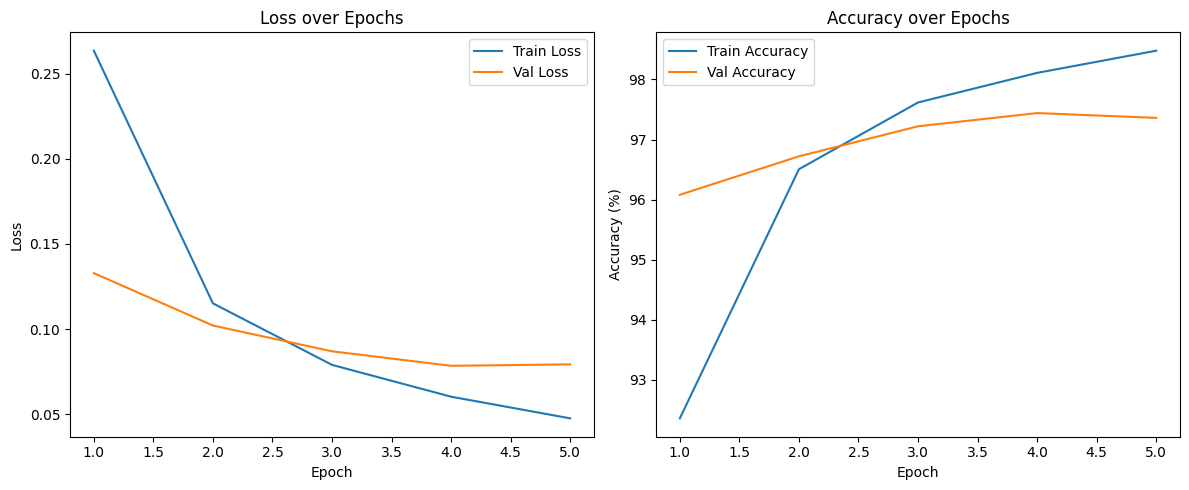

In [92]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_MLP, label='Train Loss')
plt.plot(epochs_range, val_loss_MLP, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc_MLP, label='Train Accuracy')
plt.plot(epochs_range, val_acc_MLP, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# CNN - Convolutional Neural Network

Model z warstwami konwolucyjnymi i poolingiem:

In [93]:
class CNN_1(nn.Module):
  def __init__(self):
    super().__init__()
    # pierwsza warstwa konwolucyjna
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
    self.relu1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(kernel_size=2)
    # druga warstwa konwolucyjna
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size=2)
    # warstwy w pełni połączone
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(in_features=32*7*7, out_features=128)
    self.relu3 = nn.ReLU()
    self.fc2 = nn.Linear(in_features=128, out_features=10)

  def forward(self, x):
    x = self.pool1(self.relu1(self.conv1(x)))
    x = self.pool2(self.relu2(self.conv2(x)))
    x = self.fc2(self.relu3(self.fc1(self.flatten(x))))
    return x

Trening i ewaluacja modelu:

In [94]:
model_CNN = CNN_1()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_CNN.parameters(), lr=0.001)

epochs=5
epochs_range = range(1, epochs + 1)

train_loss_CNN = []
train_acc_CNN = []
val_loss_CNN = []
val_acc_CNN =[]

for epoch in epochs_range:
    train_loss, train_acc = run_epoch(model_CNN, train_loader, criterion, optimizer, train=True, current_epoch=epoch, total_epochs=epochs)
    val_loss, val_acc = run_epoch(model_CNN, val_loader, criterion, train=False, current_epoch=epoch, total_epochs=epochs)
    train_loss_CNN.append(train_loss)
    train_acc_CNN.append(train_acc)
    val_loss_CNN.append(val_loss)
    val_acc_CNN.append(val_acc)

Epoch 1/5 (Mode: Train) - Loss: 0.1758, Accuracy: 94.64%.
Epoch 1/5 (Mode: Eval) - Loss: 0.0558, Accuracy: 98.14%.
Epoch 2/5 (Mode: Train) - Loss: 0.0528, Accuracy: 98.38%.
Epoch 2/5 (Mode: Eval) - Loss: 0.0395, Accuracy: 98.70%.
Epoch 3/5 (Mode: Train) - Loss: 0.0378, Accuracy: 98.84%.
Epoch 3/5 (Mode: Eval) - Loss: 0.0507, Accuracy: 98.28%.
Epoch 4/5 (Mode: Train) - Loss: 0.0280, Accuracy: 99.12%.
Epoch 4/5 (Mode: Eval) - Loss: 0.0301, Accuracy: 99.08%.
Epoch 5/5 (Mode: Train) - Loss: 0.0231, Accuracy: 99.25%.
Epoch 5/5 (Mode: Eval) - Loss: 0.0342, Accuracy: 98.90%.


Wizualizacja:

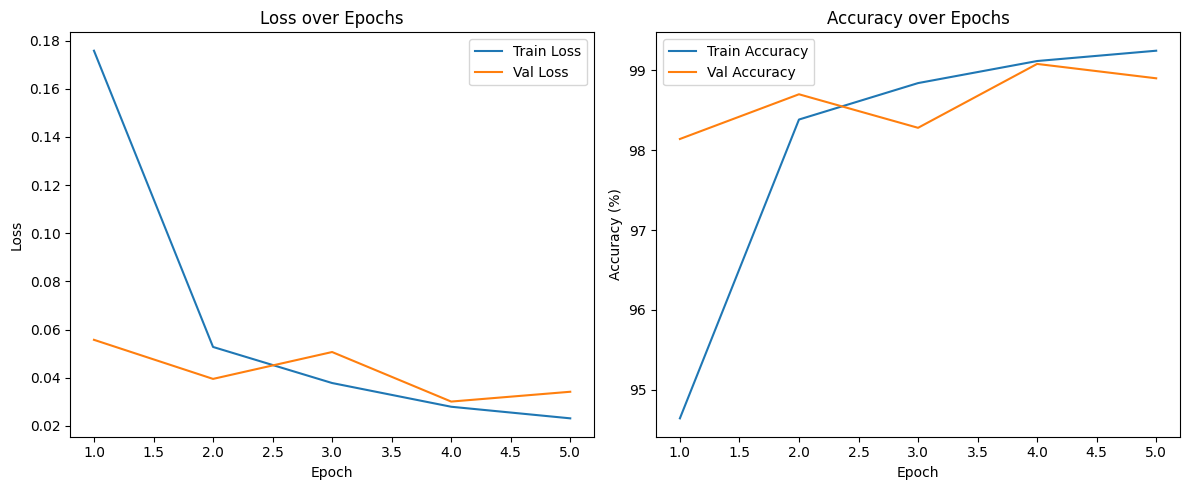

In [95]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_CNN, label='Train Loss')
plt.plot(epochs_range, val_loss_CNN, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc_CNN, label='Train Accuracy')
plt.plot(epochs_range, val_acc_CNN, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

## DROPOUT - losowe 'wyłączanie' neuronów

Poprzedni model CNN + dropout:

### 1) Dropout = 0.25

In [96]:
class CNN_2(nn.Module):
  def __init__(self):
    super().__init__()
    # pierwsza warstwa konwolucyjna
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
    self.relu1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(kernel_size=2)
    # druga warstwa konwolucyjna
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size=2)
    # warstwy w pełni połączone
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(in_features=32*7*7, out_features=128)
    self.relu3 = nn.ReLU()
    self.drop = nn.Dropout(p=0.25)
    self.fc2 = nn.Linear(in_features=128, out_features=10)

  def forward(self, x):
    x = self.pool1(self.relu1(self.conv1(x)))
    x = self.pool2(self.relu2(self.conv2(x)))
    x = self.fc2(self.drop(self.relu3(self.fc1(self.flatten(x)))))
    return x

Trening i ewaluacja modelu:

In [97]:
model_DROP = CNN_2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_DROP.parameters(), lr=0.001)

epochs=5
epochs_range = range(1, epochs + 1)

train_loss_DROP = []
train_acc_DROP = []
val_loss_DROP = []
val_acc_DROP =[]

for epoch in epochs_range:
    train_loss, train_acc = run_epoch(model_DROP, train_loader, criterion, optimizer, train=True, current_epoch=epoch, total_epochs=epochs)
    val_loss, val_acc = run_epoch(model_DROP, val_loader, criterion, train=False, current_epoch=epoch, total_epochs=epochs)
    train_loss_DROP.append(train_loss)
    train_acc_DROP.append(train_acc)
    val_loss_DROP.append(val_loss)
    val_acc_DROP.append(val_acc)

Epoch 1/5 (Mode: Train) - Loss: 0.2094, Accuracy: 93.59%.
Epoch 1/5 (Mode: Eval) - Loss: 0.0545, Accuracy: 98.26%.
Epoch 2/5 (Mode: Train) - Loss: 0.0675, Accuracy: 97.97%.
Epoch 2/5 (Mode: Eval) - Loss: 0.0396, Accuracy: 98.68%.
Epoch 3/5 (Mode: Train) - Loss: 0.0480, Accuracy: 98.52%.
Epoch 3/5 (Mode: Eval) - Loss: 0.0312, Accuracy: 98.86%.
Epoch 4/5 (Mode: Train) - Loss: 0.0386, Accuracy: 98.80%.
Epoch 4/5 (Mode: Eval) - Loss: 0.0273, Accuracy: 99.08%.
Epoch 5/5 (Mode: Train) - Loss: 0.0323, Accuracy: 98.93%.
Epoch 5/5 (Mode: Eval) - Loss: 0.0254, Accuracy: 99.08%.


Wizualizacja:

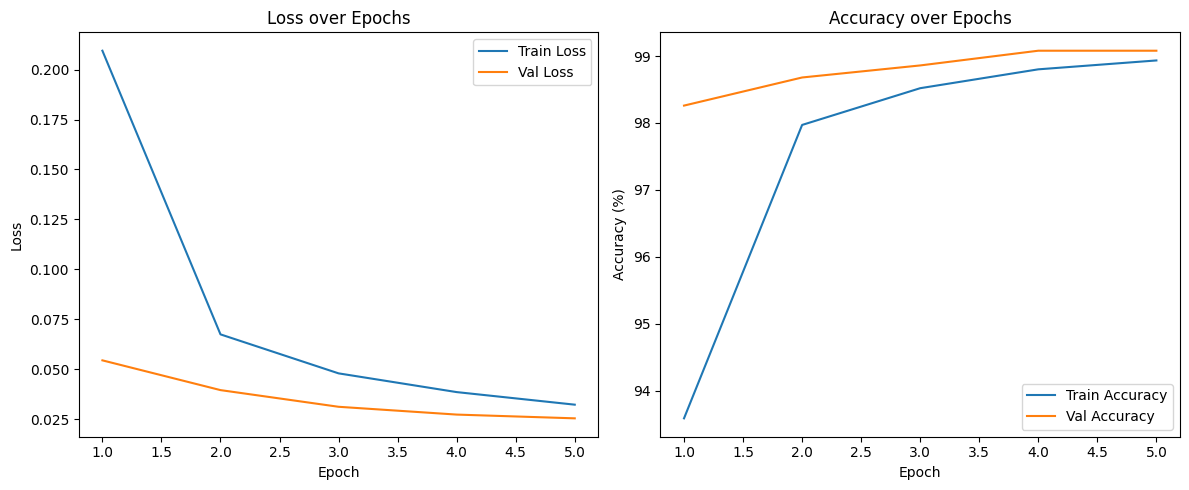

In [98]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_DROP, label='Train Loss')
plt.plot(epochs_range, val_loss_DROP, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc_DROP, label='Train Accuracy')
plt.plot(epochs_range, val_acc_DROP, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

### 2) Dropout = 0.3

In [99]:
class CNN_3(nn.Module):
  def __init__(self):
    super().__init__()
    # pierwsza warstwa konwolucyjna
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
    self.relu1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(kernel_size=2)
    # druga warstwa konwolucyjna
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size=2)
    # warstwy w pełni połączone
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(in_features=32*7*7, out_features=128)
    self.relu3 = nn.ReLU()
    self.drop = nn.Dropout(p=0.3)
    self.fc2 = nn.Linear(in_features=128, out_features=10)

  def forward(self, x):
    x = self.pool1(self.relu1(self.conv1(x)))
    x = self.pool2(self.relu2(self.conv2(x)))
    x = self.fc2(self.drop(self.relu3(self.fc1(self.flatten(x)))))
    return x

Trening i ewaluacja modelu:

In [100]:
model_DROP1 = CNN_3()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_DROP1.parameters(), lr=0.001)

epochs=5
epochs_range = range(1, epochs + 1)

train_loss_DROP1 = []
train_acc_DROP1 = []
val_loss_DROP1 = []
val_acc_DROP1 =[]

for epoch in epochs_range:
    train_loss, train_acc = run_epoch(model_DROP1, train_loader, criterion, optimizer, train=True, current_epoch=epoch, total_epochs=epochs)
    val_loss, val_acc = run_epoch(model_DROP1, val_loader, criterion, train=False, current_epoch=epoch, total_epochs=epochs)
    train_loss_DROP1.append(train_loss)
    train_acc_DROP1.append(train_acc)
    val_loss_DROP1.append(val_loss)
    val_acc_DROP1.append(val_acc)

Epoch 1/5 (Mode: Train) - Loss: 0.2152, Accuracy: 93.50%.
Epoch 1/5 (Mode: Eval) - Loss: 0.0536, Accuracy: 98.12%.
Epoch 2/5 (Mode: Train) - Loss: 0.0737, Accuracy: 97.75%.
Epoch 2/5 (Mode: Eval) - Loss: 0.0370, Accuracy: 98.68%.
Epoch 3/5 (Mode: Train) - Loss: 0.0511, Accuracy: 98.47%.
Epoch 3/5 (Mode: Eval) - Loss: 0.0369, Accuracy: 98.68%.
Epoch 4/5 (Mode: Train) - Loss: 0.0420, Accuracy: 98.69%.
Epoch 4/5 (Mode: Eval) - Loss: 0.0269, Accuracy: 99.06%.
Epoch 5/5 (Mode: Train) - Loss: 0.0358, Accuracy: 98.87%.
Epoch 5/5 (Mode: Eval) - Loss: 0.0280, Accuracy: 99.16%.


Wizualizacja:

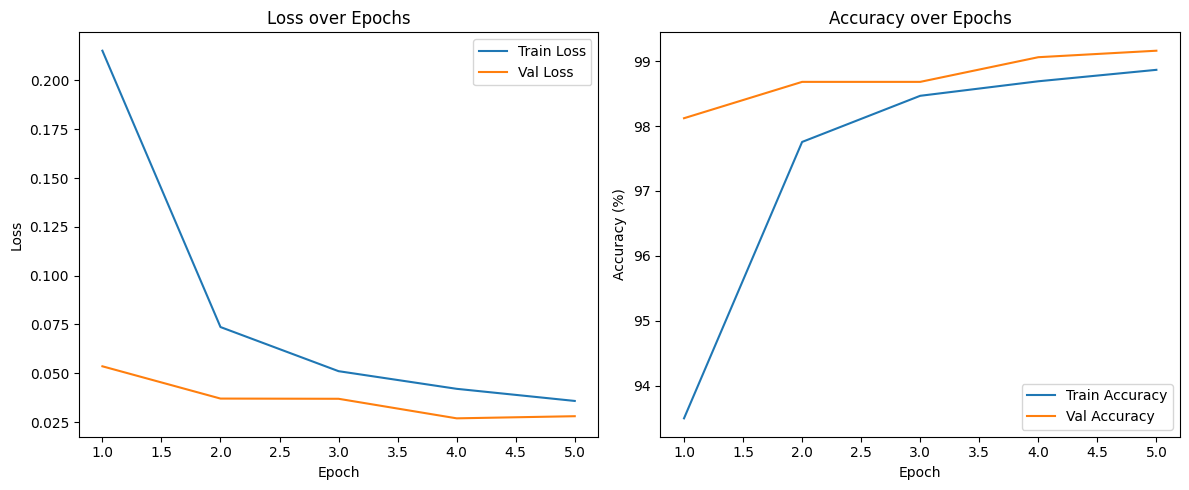

In [101]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_DROP1, label='Train Loss')
plt.plot(epochs_range, val_loss_DROP1, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc_DROP1, label='Train Accuracy')
plt.plot(epochs_range, val_acc_DROP1, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

### 3) Dropout = 0.2

In [102]:
class CNN_4(nn.Module):
  def __init__(self):
    super().__init__()
    # pierwsza warstwa konwolucyjna
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
    self.relu1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(kernel_size=2)
    # druga warstwa konwolucyjna
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size=2)
    # warstwy w pełni połączone
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(in_features=32*7*7, out_features=128)
    self.relu3 = nn.ReLU()
    self.drop = nn.Dropout(p=0.2)
    self.fc2 = nn.Linear(in_features=128, out_features=10)

  def forward(self, x):
    x = self.pool1(self.relu1(self.conv1(x)))
    x = self.pool2(self.relu2(self.conv2(x)))
    x = self.fc2(self.drop(self.relu3(self.fc1(self.flatten(x)))))
    return x

Trening i ewaluacja modelu:

In [103]:
model_DROP2 = CNN_4()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_DROP2.parameters(), lr=0.001)

epochs=5
epochs_range = range(1, epochs + 1)

train_loss_DROP2 = []
train_acc_DROP2 = []
val_loss_DROP2 = []
val_acc_DROP2 =[]

for epoch in epochs_range:
    train_loss, train_acc = run_epoch(model_DROP2, train_loader, criterion, optimizer, train=True, current_epoch=epoch, total_epochs=epochs)
    val_loss, val_acc = run_epoch(model_DROP2, val_loader, criterion, train=False, current_epoch=epoch, total_epochs=epochs)
    train_loss_DROP2.append(train_loss)
    train_acc_DROP2.append(train_acc)
    val_loss_DROP2.append(val_loss)
    val_acc_DROP2.append(val_acc)

Epoch 1/5 (Mode: Train) - Loss: 0.1873, Accuracy: 94.38%.
Epoch 1/5 (Mode: Eval) - Loss: 0.0488, Accuracy: 98.56%.
Epoch 2/5 (Mode: Train) - Loss: 0.0568, Accuracy: 98.27%.
Epoch 2/5 (Mode: Eval) - Loss: 0.0327, Accuracy: 98.98%.
Epoch 3/5 (Mode: Train) - Loss: 0.0422, Accuracy: 98.70%.
Epoch 3/5 (Mode: Eval) - Loss: 0.0283, Accuracy: 99.04%.
Epoch 4/5 (Mode: Train) - Loss: 0.0329, Accuracy: 98.97%.
Epoch 4/5 (Mode: Eval) - Loss: 0.0264, Accuracy: 99.06%.
Epoch 5/5 (Mode: Train) - Loss: 0.0263, Accuracy: 99.14%.
Epoch 5/5 (Mode: Eval) - Loss: 0.0245, Accuracy: 99.32%.


Wizualizacja:

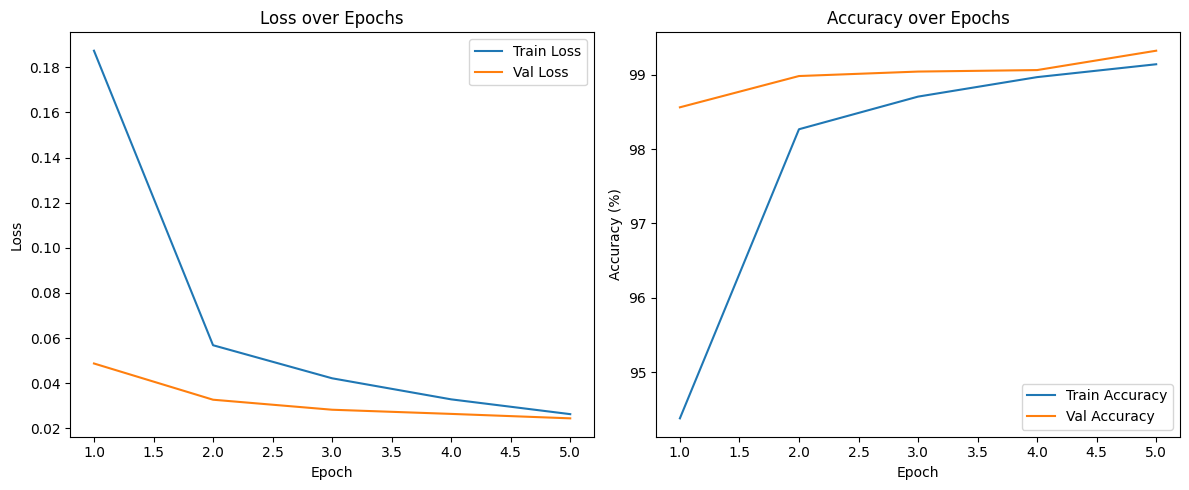

In [104]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_DROP2, label='Train Loss')
plt.plot(epochs_range, val_loss_DROP2, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc_DROP2, label='Train Accuracy')
plt.plot(epochs_range, val_acc_DROP2, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

### Podsumowanie

Jeśli chodzi o Dropout, to najlepsze wyniki udało mi się osiągnąć przy wariancie pierwszym gdzie p=0.25. To ten model dalej będę modyfikować - dodam BatchNorm.

## BATCHNORM

### 1) Po każdej warstwie konwolucyjnej

Model CNN + Dropout (p=0.25) + BatchNorm:

In [105]:
class CNN_5(nn.Module):
  def __init__(self):
    super().__init__()
    # pierwsza warstwa konwolucyjna
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(num_features=16)
    self.relu1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(kernel_size=2)
    # druga warstwa konwolucyjna
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(num_features=32)
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size=2)
    # warstwy w pełni połączone
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(in_features=32*7*7, out_features=128)
    self.relu3 = nn.ReLU()
    self.drop = nn.Dropout(p=0.25)
    self.fc2 = nn.Linear(in_features=128, out_features=10)

  def forward(self, x):
    x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
    x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
    x = self.fc2(self.drop(self.relu3(self.fc1(self.flatten(x)))))
    return x

Trening i ewaluacja modelu:

In [106]:
model_BN = CNN_5()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_BN.parameters(), lr=0.001)

epochs=5
epochs_range = range(1, epochs + 1)

train_loss_BN = []
train_acc_BN = []
val_loss_BN = []
val_acc_BN =[]

for epoch in epochs_range:
    train_loss, train_acc = run_epoch(model_BN, train_loader, criterion, optimizer, train=True, current_epoch=epoch, total_epochs=epochs)
    val_loss, val_acc = run_epoch(model_BN, val_loader, criterion, train=False, current_epoch=epoch, total_epochs=epochs)
    train_loss_BN.append(train_loss)
    train_acc_BN.append(train_acc)
    val_loss_BN.append(val_loss)
    val_acc_BN.append(val_acc)

Epoch 1/5 (Mode: Train) - Loss: 0.1769, Accuracy: 94.58%.
Epoch 1/5 (Mode: Eval) - Loss: 0.0503, Accuracy: 98.44%.
Epoch 2/5 (Mode: Train) - Loss: 0.0663, Accuracy: 98.02%.
Epoch 2/5 (Mode: Eval) - Loss: 0.0481, Accuracy: 98.30%.
Epoch 3/5 (Mode: Train) - Loss: 0.0497, Accuracy: 98.48%.
Epoch 3/5 (Mode: Eval) - Loss: 0.0310, Accuracy: 99.00%.
Epoch 4/5 (Mode: Train) - Loss: 0.0395, Accuracy: 98.73%.
Epoch 4/5 (Mode: Eval) - Loss: 0.0301, Accuracy: 99.08%.
Epoch 5/5 (Mode: Train) - Loss: 0.0342, Accuracy: 98.89%.
Epoch 5/5 (Mode: Eval) - Loss: 0.0245, Accuracy: 99.12%.


Wizualizacja:

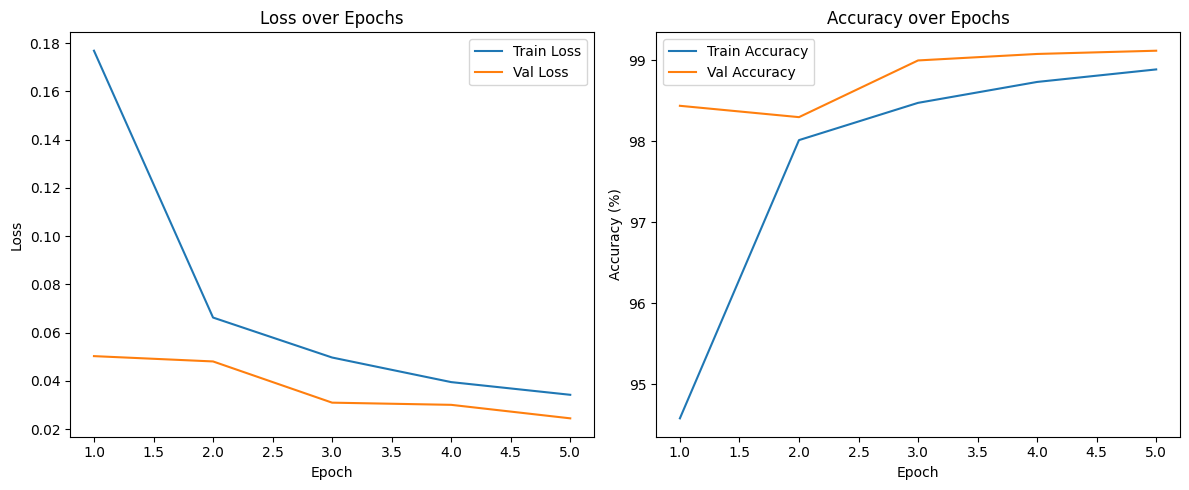

In [107]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_BN, label='Train Loss')
plt.plot(epochs_range, val_loss_BN, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc_BN, label='Train Accuracy')
plt.plot(epochs_range, val_acc_BN, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

#### 2) Bez Dropout

In [108]:
class CNN_5drop(nn.Module):
  def __init__(self):
    super().__init__()
    # pierwsza warstwa konwolucyjna
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(num_features=16)
    self.relu1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(kernel_size=2)
    # druga warstwa konwolucyjna
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(num_features=32)
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size=2)
    # warstwy w pełni połączone
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(in_features=32*7*7, out_features=128)
    self.relu3 = nn.ReLU()
    self.fc2 = nn.Linear(in_features=128, out_features=10)

  def forward(self, x):
    x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
    x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
    x = self.fc2(self.relu3(self.fc1(self.flatten(x))))
    return x

Trening i ewaluacja modelu:

In [109]:
model_BNdrop = CNN_5drop()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_BNdrop.parameters(), lr=0.001)

epochs=5
epochs_range = range(1, epochs + 1)

train_loss_BNdrop = []
train_acc_BNdrop = []
val_loss_BNdrop = []
val_acc_BNdrop =[]

for epoch in epochs_range:
    train_loss, train_acc = run_epoch(model_BNdrop, train_loader, criterion, optimizer, train=True, current_epoch=epoch, total_epochs=epochs)
    val_loss, val_acc = run_epoch(model_BNdrop, val_loader, criterion, train=False, current_epoch=epoch, total_epochs=epochs)
    train_loss_BNdrop.append(train_loss)
    train_acc_BNdrop.append(train_acc)
    val_loss_BNdrop.append(val_loss)
    val_acc_BNdrop.append(val_acc)

Epoch 1/5 (Mode: Train) - Loss: 0.1288, Accuracy: 96.13%.
Epoch 1/5 (Mode: Eval) - Loss: 0.0468, Accuracy: 98.34%.
Epoch 2/5 (Mode: Train) - Loss: 0.0498, Accuracy: 98.41%.
Epoch 2/5 (Mode: Eval) - Loss: 0.0408, Accuracy: 98.50%.
Epoch 3/5 (Mode: Train) - Loss: 0.0349, Accuracy: 98.90%.
Epoch 3/5 (Mode: Eval) - Loss: 0.0332, Accuracy: 98.80%.
Epoch 4/5 (Mode: Train) - Loss: 0.0282, Accuracy: 99.09%.
Epoch 4/5 (Mode: Eval) - Loss: 0.0344, Accuracy: 99.00%.
Epoch 5/5 (Mode: Train) - Loss: 0.0245, Accuracy: 99.20%.
Epoch 5/5 (Mode: Eval) - Loss: 0.0328, Accuracy: 98.94%.


Wizualizacja:

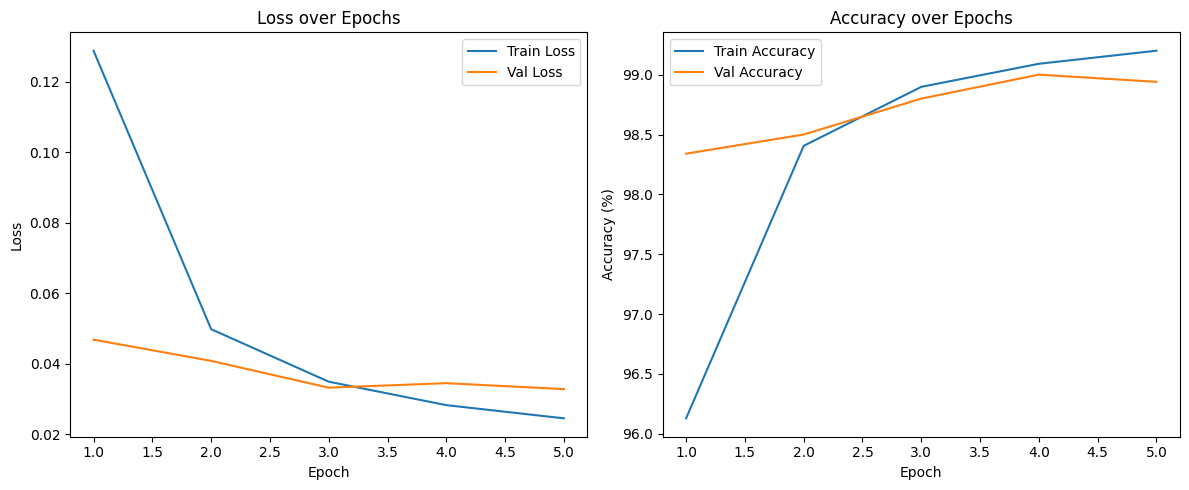

In [110]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_BNdrop, label='Train Loss')
plt.plot(epochs_range, val_loss_BNdrop, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc_BNdrop, label='Train Accuracy')
plt.plot(epochs_range, val_acc_BNdrop, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

### 3) Po warstwie w pełni połączonej

Model CNN + Dropout (p=0.25) + BatchNorm:

In [111]:
class CNN_6(nn.Module):
  def __init__(self):
    super().__init__()
    # pierwsza warstwa konwolucyjna
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
    self.relu1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(kernel_size=2)
    # druga warstwa konwolucyjna
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size=2)
    # warstwy w pełni połączone
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(in_features=32*7*7, out_features=128)
    self.bn3 = nn.BatchNorm1d(128)
    self.relu3 = nn.ReLU()
    self.drop = nn.Dropout(p=0.25)
    self.fc2 = nn.Linear(in_features=128, out_features=10)

  def forward(self, x):
    x = self.pool1(self.relu1(self.conv1(x)))
    x = self.pool2(self.relu2(self.conv2(x)))
    x = self.fc2(self.drop(self.relu3(self.bn3(self.fc1(self.flatten(x))))))
    return x

Trening i ewaluacja modelu:

In [112]:
model_BN1 = CNN_6()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_BN1.parameters(), lr=0.001)

epochs=5
epochs_range = range(1, epochs + 1)

train_loss_BN1 = []
train_acc_BN1 = []
val_loss_BN1 = []
val_acc_BN1 =[]

for epoch in epochs_range:
    train_loss, train_acc = run_epoch(model_BN1, train_loader, criterion, optimizer, train=True, current_epoch=epoch, total_epochs=epochs)
    val_loss, val_acc = run_epoch(model_BN1, val_loader, criterion, train=False, current_epoch=epoch, total_epochs=epochs)
    train_loss_BN1.append(train_loss)
    train_acc_BN1.append(train_acc)
    val_loss_BN1.append(val_loss)
    val_acc_BN1.append(val_acc)

Epoch 1/5 (Mode: Train) - Loss: 0.1359, Accuracy: 96.77%.
Epoch 1/5 (Mode: Eval) - Loss: 0.0413, Accuracy: 98.82%.
Epoch 2/5 (Mode: Train) - Loss: 0.0463, Accuracy: 98.58%.
Epoch 2/5 (Mode: Eval) - Loss: 0.0285, Accuracy: 99.10%.
Epoch 3/5 (Mode: Train) - Loss: 0.0351, Accuracy: 98.92%.
Epoch 3/5 (Mode: Eval) - Loss: 0.0303, Accuracy: 99.04%.
Epoch 4/5 (Mode: Train) - Loss: 0.0277, Accuracy: 99.09%.
Epoch 4/5 (Mode: Eval) - Loss: 0.0213, Accuracy: 99.32%.
Epoch 5/5 (Mode: Train) - Loss: 0.0221, Accuracy: 99.29%.
Epoch 5/5 (Mode: Eval) - Loss: 0.0260, Accuracy: 99.12%.


Wizualizacja:

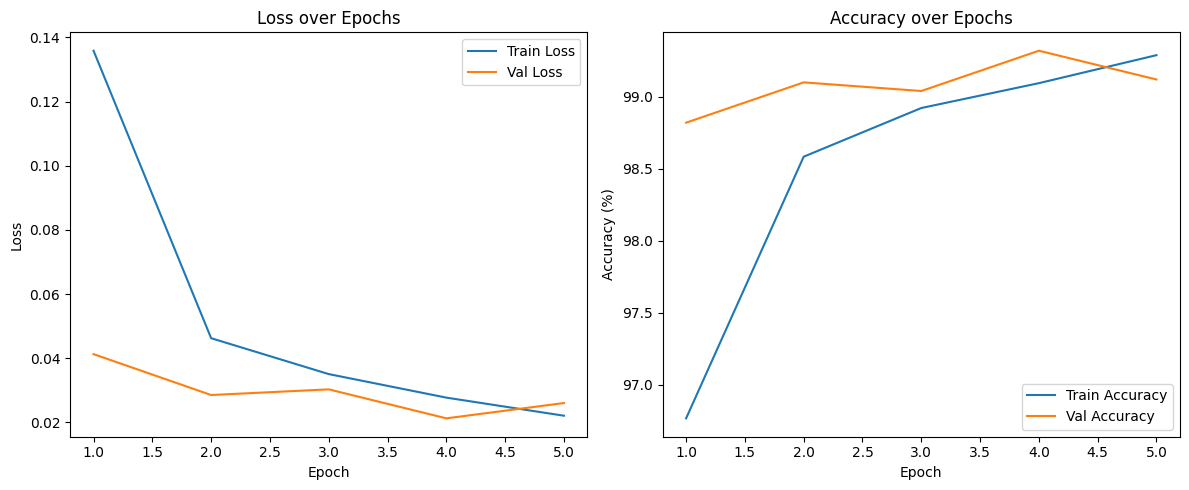

In [113]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_BN1, label='Train Loss')
plt.plot(epochs_range, val_loss_BN1, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc_BN1, label='Train Accuracy')
plt.plot(epochs_range, val_acc_BN1, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

#### 4) Bez Dropout

In [114]:
class CNN_6drop(nn.Module):
  def __init__(self):
    super().__init__()
    # pierwsza warstwa konwolucyjna
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
    self.relu1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(kernel_size=2)
    # druga warstwa konwolucyjna
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size=2)
    # warstwy w pełni połączone
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(in_features=32*7*7, out_features=128)
    self.bn3 = nn.BatchNorm1d(128)
    self.relu3 = nn.ReLU()
    self.fc2 = nn.Linear(in_features=128, out_features=10)

  def forward(self, x):
    x = self.pool1(self.relu1(self.conv1(x)))
    x = self.pool2(self.relu2(self.conv2(x)))
    x = self.fc2(self.relu3(self.bn3(self.fc1(self.flatten(x)))))
    return x

Trening i ewaluacja modelu:

In [115]:
model_BN1drop = CNN_6drop()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_BN1drop.parameters(), lr=0.001)

epochs=5
epochs_range = range(1, epochs + 1)

train_loss_BN1drop = []
train_acc_BN1drop = []
val_loss_BN1drop = []
val_acc_BN1drop =[]

for epoch in epochs_range:
    train_loss, train_acc = run_epoch(model_BN1drop, train_loader, criterion, optimizer, train=True, current_epoch=epoch, total_epochs=epochs)
    val_loss, val_acc = run_epoch(model_BN1drop, val_loader, criterion, train=False, current_epoch=epoch, total_epochs=epochs)
    train_loss_BN1drop.append(train_loss)
    train_acc_BN1drop.append(train_acc)
    val_loss_BN1drop.append(val_loss)
    val_acc_BN1drop.append(val_acc)

Epoch 1/5 (Mode: Train) - Loss: 0.1175, Accuracy: 97.08%.
Epoch 1/5 (Mode: Eval) - Loss: 0.0400, Accuracy: 98.72%.
Epoch 2/5 (Mode: Train) - Loss: 0.0386, Accuracy: 98.82%.
Epoch 2/5 (Mode: Eval) - Loss: 0.0268, Accuracy: 99.20%.
Epoch 3/5 (Mode: Train) - Loss: 0.0255, Accuracy: 99.19%.
Epoch 3/5 (Mode: Eval) - Loss: 0.0328, Accuracy: 98.94%.
Epoch 4/5 (Mode: Train) - Loss: 0.0186, Accuracy: 99.43%.
Epoch 4/5 (Mode: Eval) - Loss: 0.0223, Accuracy: 99.28%.
Epoch 5/5 (Mode: Train) - Loss: 0.0139, Accuracy: 99.57%.
Epoch 5/5 (Mode: Eval) - Loss: 0.0275, Accuracy: 99.22%.


Wizualizacja:

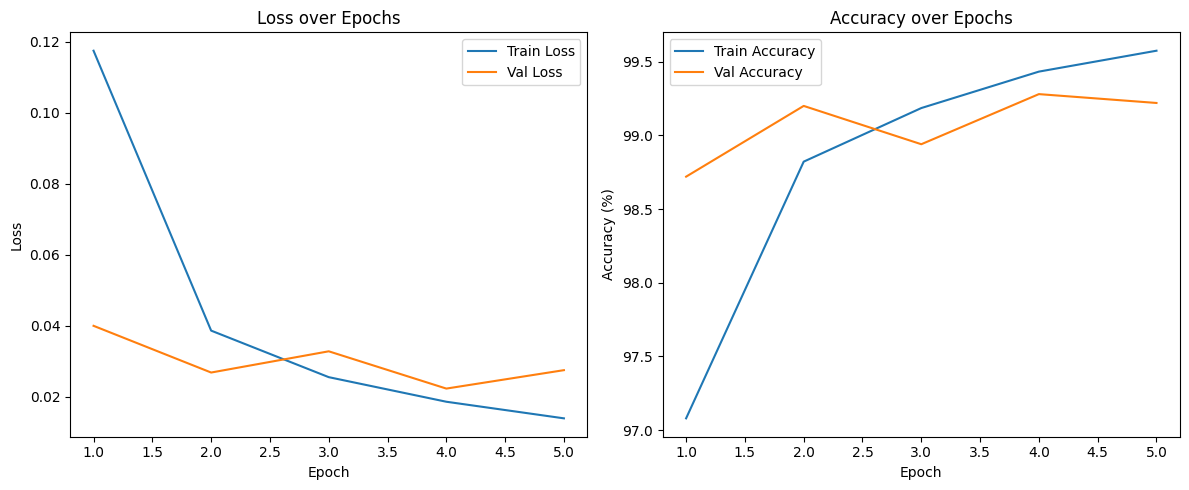

In [116]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_BN1drop, label='Train Loss')
plt.plot(epochs_range, val_loss_BN1drop, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc_BN1drop, label='Train Accuracy')
plt.plot(epochs_range, val_acc_BN1drop, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Model w czwartej epoce zaczął się przeuczać, ale w piątej nastąpiła poprawa, spróbuję zwiększyć liczbę epok - może strata jeszcze się zmniejszy a dokładność wzrośnie??

In [117]:
model_BN1drop = CNN_6drop()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_BN1drop.parameters(), lr=0.001)

epochs=7
epochs_range = range(1, epochs + 1)

train_loss_BN1drop7 = []
train_acc_BN1drop7 = []
val_loss_BN1drop7 = []
val_acc_BN1drop7 =[]

for epoch in epochs_range:
    train_loss, train_acc = run_epoch(model_BN1drop, train_loader, criterion, optimizer, train=True, current_epoch=epoch, total_epochs=epochs)
    val_loss, val_acc = run_epoch(model_BN1drop, val_loader, criterion, train=False, current_epoch=epoch, total_epochs=epochs)
    train_loss_BN1drop7.append(train_loss)
    train_acc_BN1drop7.append(train_acc)
    val_loss_BN1drop7.append(val_loss)
    val_acc_BN1drop7.append(val_acc)

Epoch 1/7 (Mode: Train) - Loss: 0.1144, Accuracy: 97.27%.
Epoch 1/7 (Mode: Eval) - Loss: 0.0350, Accuracy: 98.92%.
Epoch 2/7 (Mode: Train) - Loss: 0.0364, Accuracy: 98.91%.
Epoch 2/7 (Mode: Eval) - Loss: 0.0295, Accuracy: 99.04%.
Epoch 3/7 (Mode: Train) - Loss: 0.0242, Accuracy: 99.22%.
Epoch 3/7 (Mode: Eval) - Loss: 0.0238, Accuracy: 99.18%.
Epoch 4/7 (Mode: Train) - Loss: 0.0179, Accuracy: 99.44%.
Epoch 4/7 (Mode: Eval) - Loss: 0.0240, Accuracy: 99.30%.
Epoch 5/7 (Mode: Train) - Loss: 0.0125, Accuracy: 99.65%.
Epoch 5/7 (Mode: Eval) - Loss: 0.0413, Accuracy: 98.62%.
Epoch 6/7 (Mode: Train) - Loss: 0.0107, Accuracy: 99.64%.
Epoch 6/7 (Mode: Eval) - Loss: 0.0286, Accuracy: 99.16%.
Epoch 7/7 (Mode: Train) - Loss: 0.0087, Accuracy: 99.73%.
Epoch 7/7 (Mode: Eval) - Loss: 0.0256, Accuracy: 99.22%.


Wizualizacja:

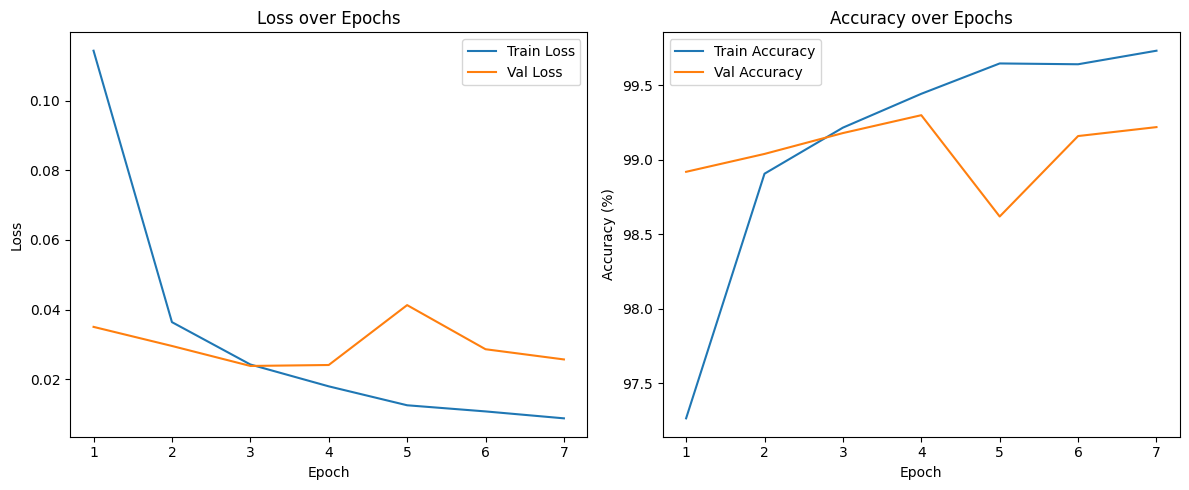

In [118]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_BN1drop7, label='Train Loss')
plt.plot(epochs_range, val_loss_BN1drop7, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc_BN1drop7, label='Train Accuracy')
plt.plot(epochs_range, val_acc_BN1drop7, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Wyniki jednak pozostały najlepsze przy pięciu epokach - nie ma potrzeby ich zwiększania.

### 5) Po każdej warstwie konwolucyjnej i po warstwie w pełni połączonej

In [119]:
class CNN_7(nn.Module):
  def __init__(self):
    super().__init__()
    # pierwsza warstwa konwolucyjna
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(num_features=16)
    self.relu1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(kernel_size=2)
    # druga warstwa konwolucyjna
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(num_features=32)
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size=2)
    # warstwy w pełni połączone
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(in_features=32*7*7, out_features=128)
    self.bn3 = nn.BatchNorm1d(num_features=128)
    self.relu3 = nn.ReLU()
    self.drop = nn.Dropout(p=0.25)
    self.fc2 = nn.Linear(in_features=128, out_features=10)

  def forward(self, x):
    x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
    x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
    x = self.fc2(self.drop(self.relu3(self.bn3(self.fc1(self.flatten(x))))))
    return x

Trening i ewaluacja modelu:

In [120]:
model_BN2 = CNN_7()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_BN2.parameters(), lr=0.001)

epochs=5
epochs_range = range(1, epochs + 1)

train_loss_BN2 = []
train_acc_BN2 = []
val_loss_BN2 = []
val_acc_BN2 =[]

for epoch in epochs_range:
    train_loss, train_acc = run_epoch(model_BN2, train_loader, criterion, optimizer, train=True, current_epoch=epoch, total_epochs=epochs)
    val_loss, val_acc = run_epoch(model_BN2, val_loader, criterion, train=False, current_epoch=epoch, total_epochs=epochs)
    train_loss_BN2.append(train_loss)
    train_acc_BN2.append(train_acc)
    val_loss_BN2.append(val_loss)
    val_acc_BN2.append(val_acc)

Epoch 1/5 (Mode: Train) - Loss: 0.1423, Accuracy: 96.60%.
Epoch 1/5 (Mode: Eval) - Loss: 0.0385, Accuracy: 98.84%.
Epoch 2/5 (Mode: Train) - Loss: 0.0499, Accuracy: 98.49%.
Epoch 2/5 (Mode: Eval) - Loss: 0.0393, Accuracy: 98.70%.
Epoch 3/5 (Mode: Train) - Loss: 0.0376, Accuracy: 98.86%.
Epoch 3/5 (Mode: Eval) - Loss: 0.0271, Accuracy: 99.04%.
Epoch 4/5 (Mode: Train) - Loss: 0.0289, Accuracy: 99.08%.
Epoch 4/5 (Mode: Eval) - Loss: 0.0230, Accuracy: 99.36%.
Epoch 5/5 (Mode: Train) - Loss: 0.0225, Accuracy: 99.26%.
Epoch 5/5 (Mode: Eval) - Loss: 0.0268, Accuracy: 99.10%.


Wizualizacja:

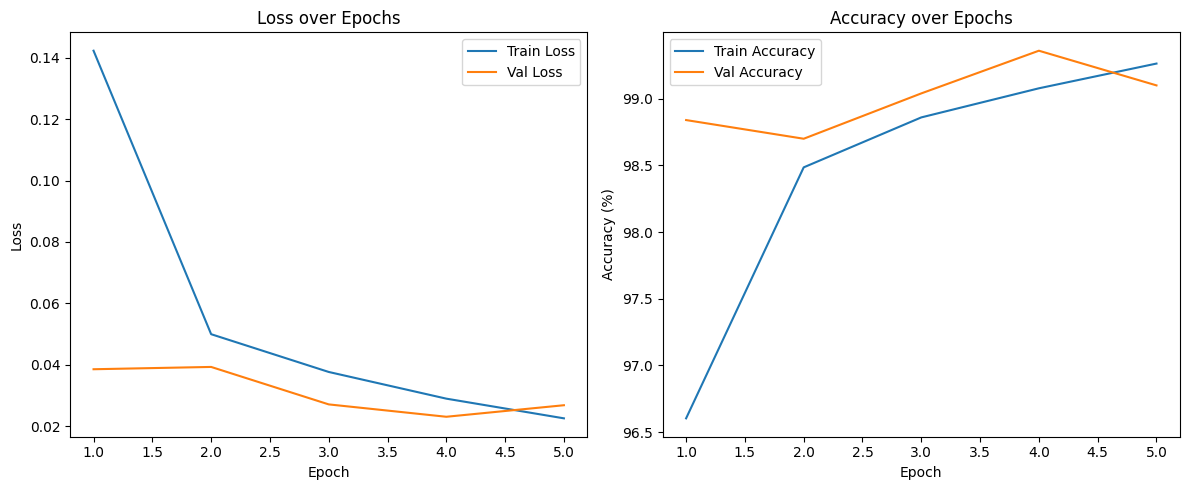

In [121]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_BN2, label='Train Loss')
plt.plot(epochs_range, val_loss_BN2, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc_BN2, label='Train Accuracy')
plt.plot(epochs_range, val_acc_BN2, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Model jeszcze się uczy, spróbuje zwiększyć liczbę epok - może wyniki jeszcze się poprawią??

In [122]:
model_BN2 = CNN_7()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_BN2.parameters(), lr=0.001)

epochs=10
epochs_range = range(1, epochs + 1)

train_loss_BN210 = []
train_acc_BN210 = []
val_loss_BN210 = []
val_acc_BN210 =[]

for epoch in epochs_range:
    train_loss, train_acc = run_epoch(model_BN2, train_loader, criterion, optimizer, train=True, current_epoch=epoch, total_epochs=epochs)
    val_loss, val_acc = run_epoch(model_BN2, val_loader, criterion, train=False, current_epoch=epoch, total_epochs=epochs)
    train_loss_BN210.append(train_loss)
    train_acc_BN210.append(train_acc)
    val_loss_BN210.append(val_loss)
    val_acc_BN210.append(val_acc)

Epoch 1/10 (Mode: Train) - Loss: 0.1370, Accuracy: 96.61%.
Epoch 1/10 (Mode: Eval) - Loss: 0.0427, Accuracy: 98.70%.
Epoch 2/10 (Mode: Train) - Loss: 0.0493, Accuracy: 98.52%.
Epoch 2/10 (Mode: Eval) - Loss: 0.0310, Accuracy: 99.30%.
Epoch 3/10 (Mode: Train) - Loss: 0.0355, Accuracy: 98.92%.
Epoch 3/10 (Mode: Eval) - Loss: 0.0281, Accuracy: 99.08%.
Epoch 4/10 (Mode: Train) - Loss: 0.0279, Accuracy: 99.13%.
Epoch 4/10 (Mode: Eval) - Loss: 0.0267, Accuracy: 99.16%.
Epoch 5/10 (Mode: Train) - Loss: 0.0234, Accuracy: 99.27%.
Epoch 5/10 (Mode: Eval) - Loss: 0.0252, Accuracy: 99.20%.
Epoch 6/10 (Mode: Train) - Loss: 0.0195, Accuracy: 99.37%.
Epoch 6/10 (Mode: Eval) - Loss: 0.0279, Accuracy: 99.06%.
Epoch 7/10 (Mode: Train) - Loss: 0.0166, Accuracy: 99.46%.
Epoch 7/10 (Mode: Eval) - Loss: 0.0305, Accuracy: 99.08%.
Epoch 8/10 (Mode: Train) - Loss: 0.0149, Accuracy: 99.54%.
Epoch 8/10 (Mode: Eval) - Loss: 0.0239, Accuracy: 99.28%.
Epoch 9/10 (Mode: Train) - Loss: 0.0131, Accuracy: 99.56%.
Epoch

Wizualizacja:

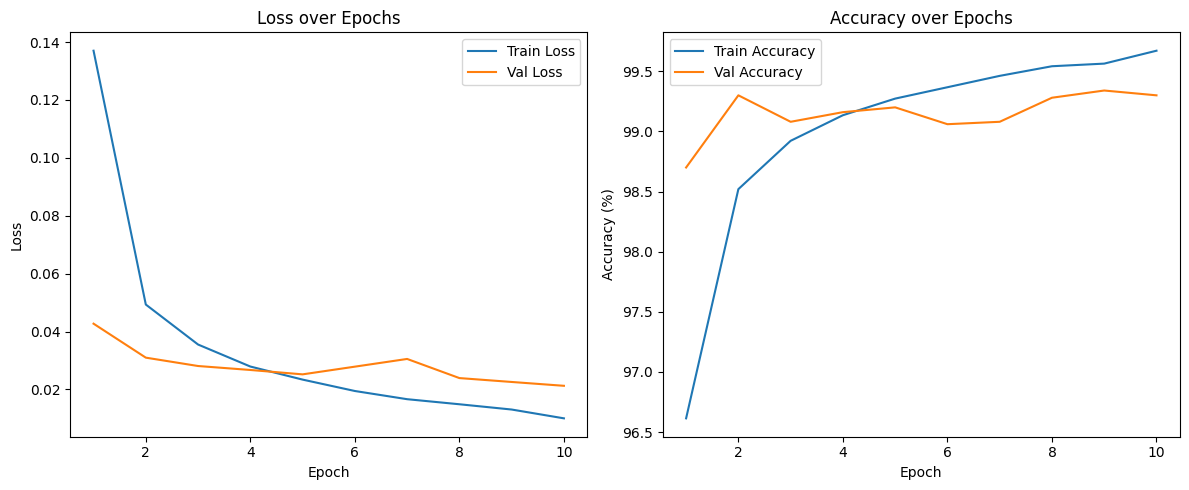

In [123]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_BN210, label='Train Loss')
plt.plot(epochs_range, val_loss_BN210, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc_BN210, label='Train Accuracy')
plt.plot(epochs_range, val_acc_BN210, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

#### 6) Bez dropout

In [124]:
class CNN_7drop(nn.Module):
  def __init__(self):
    super().__init__()
    # pierwsza warstwa konwolucyjna
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(num_features=16)
    self.relu1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(kernel_size=2)
    # druga warstwa konwolucyjna
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(num_features=32)
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size=2)
    # warstwy w pełni połączone
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(in_features=32*7*7, out_features=128)
    self.bn3 = nn.BatchNorm1d(num_features=128)
    self.relu3 = nn.ReLU()
    self.fc2 = nn.Linear(in_features=128, out_features=10)

  def forward(self, x):
    x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
    x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
    x = self.fc2(self.relu3(self.bn3(self.fc1(self.flatten(x)))))
    return x

Trening i ewaluacja modelu:

In [125]:
model_BN2drop = CNN_7drop()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_BN2drop.parameters(), lr=0.001)

epochs=10
epochs_range = range(1, epochs + 1)

train_loss_BN2drop10 = []
train_acc_BN2drop10 = []
val_loss_BN2drop10 = []
val_acc_BN2drop10 =[]

for epoch in epochs_range:
    train_loss, train_acc = run_epoch(model_BN2drop, train_loader, criterion, optimizer, train=True, current_epoch=epoch, total_epochs=epochs)
    val_loss, val_acc = run_epoch(model_BN2drop, val_loader, criterion, train=False, current_epoch=epoch, total_epochs=epochs)
    train_loss_BN2drop10.append(train_loss)
    train_acc_BN2drop10.append(train_acc)
    val_loss_BN2drop10.append(val_loss)
    val_acc_BN2drop10.append(val_acc)

Epoch 1/10 (Mode: Train) - Loss: 0.1210, Accuracy: 97.08%.
Epoch 1/10 (Mode: Eval) - Loss: 0.0385, Accuracy: 98.84%.
Epoch 2/10 (Mode: Train) - Loss: 0.0392, Accuracy: 98.85%.
Epoch 2/10 (Mode: Eval) - Loss: 0.0272, Accuracy: 99.20%.
Epoch 3/10 (Mode: Train) - Loss: 0.0267, Accuracy: 99.21%.
Epoch 3/10 (Mode: Eval) - Loss: 0.0241, Accuracy: 99.30%.
Epoch 4/10 (Mode: Train) - Loss: 0.0208, Accuracy: 99.35%.
Epoch 4/10 (Mode: Eval) - Loss: 0.0211, Accuracy: 99.36%.
Epoch 5/10 (Mode: Train) - Loss: 0.0157, Accuracy: 99.53%.
Epoch 5/10 (Mode: Eval) - Loss: 0.0253, Accuracy: 99.18%.
Epoch 6/10 (Mode: Train) - Loss: 0.0113, Accuracy: 99.66%.
Epoch 6/10 (Mode: Eval) - Loss: 0.0257, Accuracy: 99.18%.
Epoch 7/10 (Mode: Train) - Loss: 0.0112, Accuracy: 99.62%.
Epoch 7/10 (Mode: Eval) - Loss: 0.0221, Accuracy: 99.14%.
Epoch 8/10 (Mode: Train) - Loss: 0.0094, Accuracy: 99.70%.
Epoch 8/10 (Mode: Eval) - Loss: 0.0184, Accuracy: 99.40%.
Epoch 9/10 (Mode: Train) - Loss: 0.0060, Accuracy: 99.82%.
Epoch

Wizualizacja:

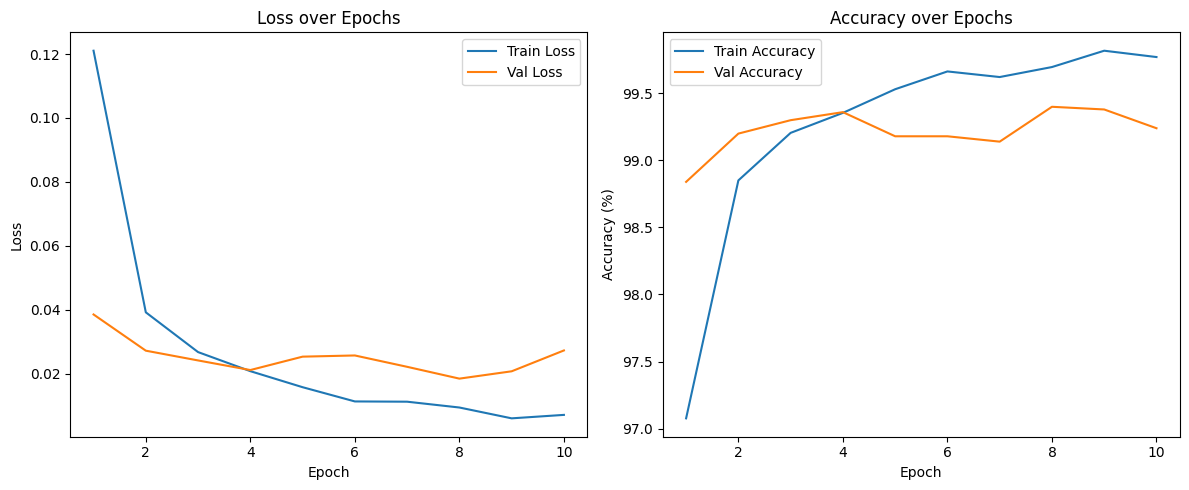

In [126]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_BN2drop10, label='Train Loss')
plt.plot(epochs_range, val_loss_BN2drop10, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc_BN2drop10, label='Train Accuracy')
plt.plot(epochs_range, val_acc_BN2drop10, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Jeśli chodzi o hiperparametr BatchNorm to najlepsze wyniki udało mi się uzyskać w wariancie piątym -> Dropout: p=0.25, a BatchNorm po każdej warstwie konwolucyjnej i po warstwie w pełni połączonej przy 10 epokach.
* Epoch 8/10 (Mode: Train) - Loss: 0.0149, Accuracy: 99.54%.
* Epoch 8/10 (Mode: Eval) - Loss: 0.0239, Accuracy: 99.28%.
* Epoch 9/10 (Mode: Train) - Loss: 0.0131, Accuracy: 99.56%.
* Epoch 9/10 (Mode: Eval) - Loss: 0.0226, Accuracy: 99.34%.
* Epoch 10/10 (Mode: Train) - Loss: 0.0100, Accuracy: 99.67%.
* Epoch 10/10 (Mode: Eval) - Loss: 0.0213, Accuracy: 99.30%.

Wybrałam ten model ponieważ ma:
* niższy eval loss - model bardziej pewny swoich predykcji
* stabilną eval accuracy - mniej fluktuacji, większa przewidywalność
* lepszy stosunek train/eval - nie przeucza się mimo wysokiej skuteczności.

Teraz mogę ten model ulepszyć - np. o kolejną warstwę konwolucyjną.

## Trzecia warstwa konwolucyjna

In [127]:
class CNN_final(nn.Module):
  def __init__(self):
    super().__init__()
    # pierwsza warstwa konwolucyjna
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(num_features=16)
    self.relu1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(kernel_size=2)
    # druga warstwa konwolucyjna
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(num_features=32)
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size=2)
    # trzecia warstwa konwolucyjna
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.bn3 = nn.BatchNorm2d(num_features=64)
    self.relu3 = nn.ReLU()
    self.pool3 = nn.MaxPool2d(kernel_size=2)
    # warstwy w pełni połączone
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(in_features=64*3*3, out_features=256)
    self.bn4 = nn.BatchNorm1d(num_features=256)
    self.relu4 = nn.ReLU()
    self.drop = nn.Dropout(p=0.25)
    self.fc2 = nn.Linear(in_features=256, out_features=10)

  def forward(self, x):
    x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
    x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
    x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
    x = self.fc2(self.drop(self.relu4(self.bn4(self.fc1(self.flatten(x))))))
    return x

Trening i ewaluacja modelu:

In [128]:
model_CNNfinal = CNN_final()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_CNNfinal.parameters(), lr=0.001)

epochs=10
epochs_range = range(1, epochs + 1)

train_loss_CNNfinal = []
train_acc_CNNfinal = []
val_loss_CNNfinal = []
val_acc_CNNfinal =[]

for epoch in epochs_range:
    train_loss, train_acc = run_epoch(model_CNNfinal, train_loader, criterion, optimizer, train=True, current_epoch=epoch, total_epochs=epochs)
    val_loss, val_acc = run_epoch(model_CNNfinal, val_loader, criterion, train=False, current_epoch=epoch, total_epochs=epochs)
    train_loss_CNNfinal.append(train_loss)
    train_acc_CNNfinal.append(train_acc)
    val_loss_CNNfinal.append(val_loss)
    val_acc_CNNfinal.append(val_acc)

Epoch 1/10 (Mode: Train) - Loss: 0.1111, Accuracy: 97.03%.
Epoch 1/10 (Mode: Eval) - Loss: 0.0291, Accuracy: 99.08%.
Epoch 2/10 (Mode: Train) - Loss: 0.0410, Accuracy: 98.68%.
Epoch 2/10 (Mode: Eval) - Loss: 0.0310, Accuracy: 98.88%.
Epoch 3/10 (Mode: Train) - Loss: 0.0287, Accuracy: 99.09%.
Epoch 3/10 (Mode: Eval) - Loss: 0.0226, Accuracy: 99.30%.
Epoch 4/10 (Mode: Train) - Loss: 0.0250, Accuracy: 99.21%.
Epoch 4/10 (Mode: Eval) - Loss: 0.0253, Accuracy: 99.28%.
Epoch 5/10 (Mode: Train) - Loss: 0.0191, Accuracy: 99.44%.
Epoch 5/10 (Mode: Eval) - Loss: 0.0245, Accuracy: 99.16%.
Epoch 6/10 (Mode: Train) - Loss: 0.0170, Accuracy: 99.43%.
Epoch 6/10 (Mode: Eval) - Loss: 0.0239, Accuracy: 99.30%.
Epoch 7/10 (Mode: Train) - Loss: 0.0142, Accuracy: 99.53%.
Epoch 7/10 (Mode: Eval) - Loss: 0.0180, Accuracy: 99.44%.
Epoch 8/10 (Mode: Train) - Loss: 0.0116, Accuracy: 99.63%.
Epoch 8/10 (Mode: Eval) - Loss: 0.0168, Accuracy: 99.54%.
Epoch 9/10 (Mode: Train) - Loss: 0.0104, Accuracy: 99.67%.
Epoch

Wizualizacja:

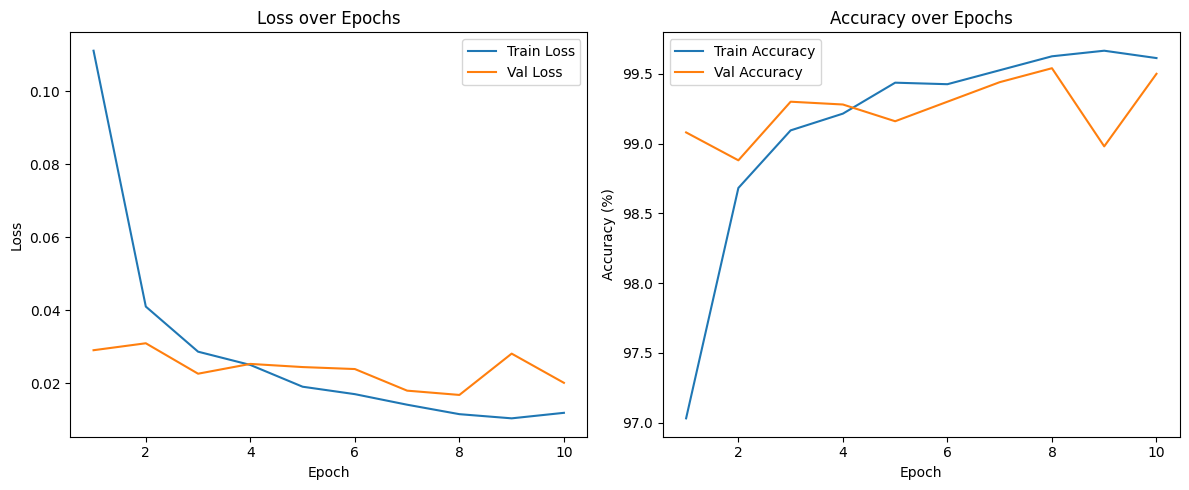

In [129]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_CNNfinal, label='Train Loss')
plt.plot(epochs_range, val_loss_CNNfinal, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc_CNNfinal, label='Train Accuracy')
plt.plot(epochs_range, val_acc_CNNfinal, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Dodam jeszcze dropout po każdej warstwie konwolucyjnej i wybiorę najlepszy model dla którego wykonam ewaluację na zbiorze testowym.

# Finalny model

In [130]:
class CNN_last(nn.Module):
  def __init__(self):
    super().__init__()
    # pierwsza warstwa konwolucyjna
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(num_features=16)
    self.relu1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(kernel_size=2)
    self.drop1 = nn.Dropout2d(p=0.1)
    # druga warstwa konwolucyjna
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(num_features=32)
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size=2)
    self.drop2 = nn.Dropout2d(p=0.15)
    # trzecia warstwa konwolucyjna
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.bn3 = nn.BatchNorm2d(num_features=64)
    self.relu3 = nn.ReLU()
    self.pool3 = nn.MaxPool2d(kernel_size=2)
    self.drop3 = nn.Dropout2d(p=0.2)
    # warstwy w pełni połączone
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(in_features=64*3*3, out_features=256)
    self.bn4 = nn.BatchNorm1d(num_features=256)
    self.relu4 = nn.ReLU()
    self.drop = nn.Dropout(p=0.25)
    self.fc2 = nn.Linear(in_features=256, out_features=10)

  def forward(self, x):
    x = self.pool1(self.drop1(self.relu1(self.bn1(self.conv1(x)))))
    x = self.pool2(self.drop2(self.relu2(self.bn2(self.conv2(x)))))
    x = self.pool3(self.drop3(self.relu3(self.bn3(self.conv3(x)))))
    x = self.fc2(self.drop(self.relu4(self.bn4(self.fc1(self.flatten(x))))))
    return x

Trening i ewaluacja modelu:

In [131]:
model_last = CNN_last()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_last.parameters(), lr=0.001)

epochs=10
epochs_range = range(1, epochs + 1)

train_loss_last = []
train_acc_last = []
val_loss_last = []
val_acc_last =[]

for epoch in epochs_range:
    train_loss, train_acc = run_epoch(model_last, train_loader, criterion, optimizer, train=True, current_epoch=epoch, total_epochs=epochs)
    val_loss, val_acc = run_epoch(model_last, val_loader, criterion, train=False, current_epoch=epoch, total_epochs=epochs)
    train_loss_last.append(train_loss)
    train_acc_last.append(train_acc)
    val_loss_last.append(val_loss)
    val_acc_last.append(val_acc)

Epoch 1/10 (Mode: Train) - Loss: 0.1837, Accuracy: 94.73%.
Epoch 1/10 (Mode: Eval) - Loss: 0.0355, Accuracy: 98.94%.
Epoch 2/10 (Mode: Train) - Loss: 0.0670, Accuracy: 97.92%.
Epoch 2/10 (Mode: Eval) - Loss: 0.0290, Accuracy: 99.06%.
Epoch 3/10 (Mode: Train) - Loss: 0.0551, Accuracy: 98.31%.
Epoch 3/10 (Mode: Eval) - Loss: 0.0251, Accuracy: 99.18%.
Epoch 4/10 (Mode: Train) - Loss: 0.0436, Accuracy: 98.61%.
Epoch 4/10 (Mode: Eval) - Loss: 0.0258, Accuracy: 99.22%.
Epoch 5/10 (Mode: Train) - Loss: 0.0403, Accuracy: 98.72%.
Epoch 5/10 (Mode: Eval) - Loss: 0.0189, Accuracy: 99.44%.
Epoch 6/10 (Mode: Train) - Loss: 0.0354, Accuracy: 98.81%.
Epoch 6/10 (Mode: Eval) - Loss: 0.0226, Accuracy: 99.22%.
Epoch 7/10 (Mode: Train) - Loss: 0.0341, Accuracy: 98.87%.
Epoch 7/10 (Mode: Eval) - Loss: 0.0177, Accuracy: 99.46%.
Epoch 8/10 (Mode: Train) - Loss: 0.0308, Accuracy: 98.98%.
Epoch 8/10 (Mode: Eval) - Loss: 0.0176, Accuracy: 99.52%.
Epoch 9/10 (Mode: Train) - Loss: 0.0273, Accuracy: 99.11%.
Epoch

Wizualizacja:

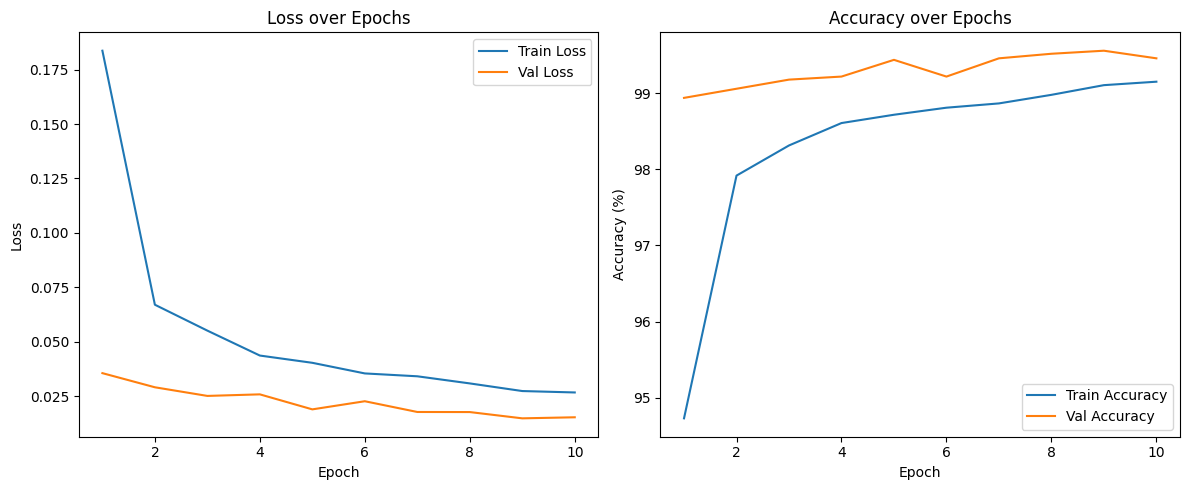

In [132]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_last, label='Train Loss')
plt.plot(epochs_range, val_loss_last, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc_last, label='Train Accuracy')
plt.plot(epochs_range, val_acc_last, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Powyższy model uzyskał najlepsze wyniki:
* Epoch 8/10 (Mode: Train) - Loss: 0.0308, Accuracy: 98.98%.
- Epoch 8/10 (Mode: Eval) - Loss: 0.0176, Accuracy: 99.52%.
- Epoch 9/10 (Mode: Train) - Loss: 0.0273, Accuracy: 99.11%.
- Epoch 9/10 (Mode: Eval) - Loss: 0.0148, Accuracy: 99.56%.
- Epoch 10/10 (Mode: Train) - Loss: 0.0267, Accuracy: 99.15%.
- Epoch 10/10 (Mode: Eval) - Loss: 0.0152, Accuracy: 99.46%.

Teraz czas na finalny test.

# Test modelu

Test accuracy: 0.9899


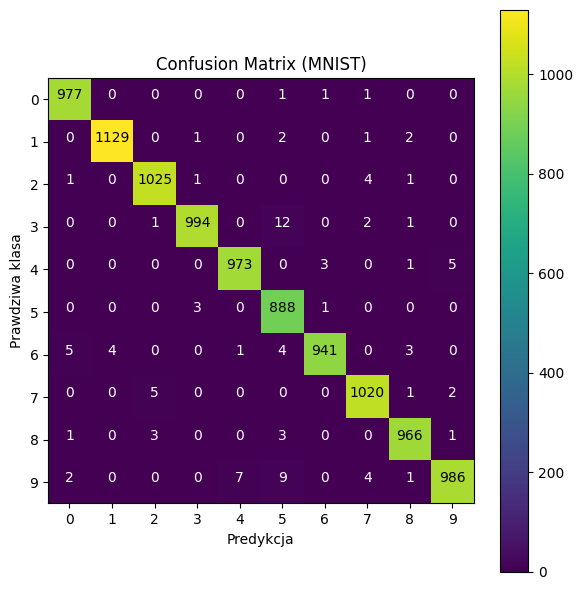

              precision    recall  f1-score   support

           0     0.9909    0.9969    0.9939       980
           1     0.9965    0.9947    0.9956      1135
           2     0.9913    0.9932    0.9923      1032
           3     0.9950    0.9842    0.9895      1010
           4     0.9918    0.9908    0.9913       982
           5     0.9663    0.9955    0.9807       892
           6     0.9947    0.9823    0.9884       958
           7     0.9884    0.9922    0.9903      1028
           8     0.9898    0.9918    0.9908       974
           9     0.9920    0.9772    0.9845      1009

    accuracy                         0.9899     10000
   macro avg     0.9897    0.9899    0.9897     10000
weighted avg     0.9900    0.9899    0.9899     10000



In [135]:
model_last.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device, non_blocking=True)
        logits = model(xb)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(yb.numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_targets)

test_acc = (y_pred == y_true).mean()
print(f"Test accuracy: {test_acc:.4f}")


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (MNIST)")
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="black" if cm[i, j] > thresh else "white")

plt.ylabel('Prawdziwa klasa')
plt.xlabel('Predykcja')
plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred, digits=4))

# Wizualizacja predykcji

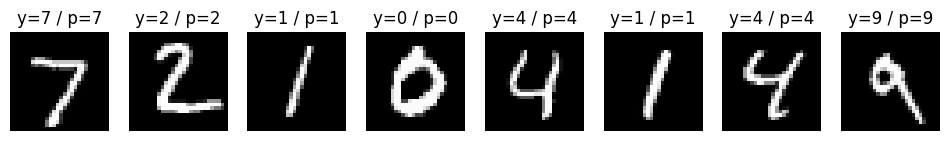

In [134]:
model.eval()
images, labels = next(iter(test_loader))
images, labels = images[:8], labels[:8]
with torch.no_grad():
    logits = model(images.to(device))
preds = logits.argmax(1).cpu()

fig, axes = plt.subplots(1, len(images), figsize=(12, 2.5))
for ax, img, y, p in zip(axes, images, labels, preds):
    ax.imshow(img.squeeze().numpy(), cmap="gray")
    ax.set_title(f"y={y.item()} / p={int(p)}")
    ax.axis("off")
plt.show()

Zapis modelu

In [136]:
save_path = "mnist_cnn.pt"
torch.save(model_last.state_dict(), save_path)
print(f"Model zapisany do: {os.path.abspath(save_path)}")

# do ładowania odkomentuj poniższe:
# Ładowanie:
# model = SimpleCNN().to(device)
# model.load_state_dict(torch.load(save_path, map_location=device))
# model.eval()

Model zapisany do: /content/mnist_cnn.pt
